In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import SCORERS
from sklearn.metrics import r2_score

In [181]:
df = pd.read_csv("abalone.csv")

In [182]:
df.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


In [183]:
df.Rings.unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [184]:
X = df.drop(columns = 'Rings')

In [185]:
df['age'] = df['Rings']+1.5
y = df['age']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [187]:
X_train_alive = X_train[['Sex','Length','Diameter','Height', 'Whole weight']]
X_test_alive = X_test[['Sex','Length','Diameter','Height', 'Whole weight']]

In [188]:
import math

class AreaTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''A=πab'''
        X_ = X.copy()
        X_["area"] = math.pi * X_['Length'] * X_['Diameter']
        return X_[["area"]]

In [189]:
trans = ColumnTransformer(
    [('ohe', OneHotEncoder(drop = 'first'), ['Sex']),
    ('area', AreaTransformer(), ['Length', 'Diameter'])],
    remainder = 'passthrough')

In [190]:
preproc = Pipeline([
    ('encoder', trans),
    ('scaler', StandardScaler())
])

In [191]:
lin_reg = Pipeline([
    ('preproc', preproc),
    ('model', LinearRegression())
])

In [192]:
gbr = Pipeline([
    ('preproc', preproc),
    ('gbr', GradientBoostingRegressor(n_estimators=500, 
                               learning_rate=0.2,
                               max_depth=1))
])

In [193]:
rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(n_estimators = 400))  
])


In [118]:
res = cross_validate(lin_reg, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.6110005746171052
% error:  -0.14085498307289604
r2:  0.49347782903178816


In [120]:
res = cross_validate(gbr, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5911960828471206
% error:  -0.1364910742325986
r2:  0.530506721386295


In [121]:
res = cross_validate(rf, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5603701220583068
% error:  -0.13366143834958985
r2:  0.5365793019802574


In [98]:
rf.get_params()

{'memory': None,
 'steps': [('preproc', Pipeline(steps=[('encoder',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('ohe',
                                                     OneHotEncoder(drop='first'),
                                                     ['Sex'])])),
                   ('scaler', StandardScaler())])),
  ('rf', RandomForestRegressor(n_estimators=400))],
 'verbose': False,
 'preproc': Pipeline(steps=[('encoder',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   OneHotEncoder(drop='first'),
                                                   ['Sex'])])),
                 ('scaler', StandardScaler())]),
 'rf': RandomForestRegressor(n_estimators=400),
 'preproc__memory': None,
 'preproc__steps': [('encoder',
   ColumnTransformer(remainder='passthrough',
                     transformers=

In [174]:
params = {'rf__max_depth': [6, 7, 8, 9, 10],
         'rf__n_estimators': [200, 400, 600, 800]}

In [175]:
grid = GridSearchCV(rf, params, verbose = 3, cv = 3)

In [176]:
gs_res = grid.fit(X_train_alive, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END rf__max_depth=6, rf__n_estimators=200;, score=0.382 total time=   0.5s
[CV 2/3] END rf__max_depth=6, rf__n_estimators=200;, score=0.425 total time=   0.5s
[CV 3/3] END rf__max_depth=6, rf__n_estimators=200;, score=0.396 total time=   0.6s
[CV 1/3] END rf__max_depth=6, rf__n_estimators=400;, score=0.380 total time=   1.4s
[CV 2/3] END rf__max_depth=6, rf__n_estimators=400;, score=0.425 total time=   1.4s
[CV 3/3] END rf__max_depth=6, rf__n_estimators=400;, score=0.399 total time=   1.1s
[CV 1/3] END rf__max_depth=6, rf__n_estimators=600;, score=0.382 total time=   1.5s
[CV 2/3] END rf__max_depth=6, rf__n_estimators=600;, score=0.426 total time=   1.4s
[CV 3/3] END rf__max_depth=6, rf__n_estimators=600;, score=0.396 total time=   1.5s
[CV 1/3] END rf__max_depth=6, rf__n_estimators=800;, score=0.382 total time=   2.0s
[CV 2/3] END rf__max_depth=6, rf__n_estimators=800;, score=0.426 total time=   2.1s
[CV 3/3] END rf

In [177]:
gs_res.best_estimator_

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['Sex']),
                                                                  ('area',
                                                                   AreaTransformer(),
                                                                   ['Length',
                                                                    'Diameter'])])),
                                 ('scaler', StandardScaler())])),
                ('rf', RandomForestRegressor(max_depth=6, n_estimators=400))])

In [178]:
gs_res.best_score_

0.4015247747776196

In [155]:
preproc.fit_transform(X_train).shape

(2923, 8)

In [172]:
best_rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(max_depth=8, n_estimators=400))  
])


res = cross_validate(best_rf, 
               X_train, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.5254189963807714
% error:  -0.13003147892577482
r2:  0.5461044022951305


In [194]:
small_rf = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(max_depth=6, n_estimators=400))  
])
 

In [179]:
res = cross_validate(small_rf, 
               X_train_alive, 
               y_train, 
               cv = 5, 
               scoring = ['neg_mean_absolute_error','neg_mean_absolute_percentage_error', 'r2'])

print('abs error: ', res['test_neg_mean_absolute_error'].mean())
print('% error: ', res['test_neg_mean_absolute_percentage_error'].mean())
print('r2: ', res['test_r2'].mean())

abs error:  -1.772041407011553
% error:  -0.14995807528448585
r2:  0.40173318011294723


In [196]:
small_rf.fit(X_train_alive, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['Sex']),
                                                                  ('area',
                                                                   AreaTransformer(),
                                                                   ['Length',
                                                                    'Diameter'])])),
                                 ('scaler', StandardScaler())])),
                ('rf', RandomForestRegressor(max_depth=6, n_estimators=400))])

In [198]:
y_pred = small_rf.predict(X_test_alive)

In [199]:
e = y_test - y_pred

(array([  3.,   3.,   4.,   6.,   9.,  24.,  32.,  74.,  84., 142., 124.,
        158.,  92., 110.,  76.,  59.,  46.,  35.,  28.,  24.,  25.,  10.,
         18.,   8.,   7.,   7.,   9.,   5.,   8.,   2.,   3.,   4.,   1.,
          6.,   1.,   1.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-5.80380554, -5.34313352, -4.8824615 , -4.42178949, -3.96111747,
        -3.50044546, -3.03977344, -2.57910142, -2.11842941, -1.65775739,
        -1.19708537, -0.73641336, -0.27574134,  0.18493068,  0.64560269,
         1.10627471,  1.56694673,  2.02761874,  2.48829076,  2.94896278,
         3.40963479,  3.87030681,  4.33097883,  4.79165084,  5.25232286,
         5.71299488,  6.17366689,  6.63433891,  7.09501093,  7.55568294,
         8.01635496,  8.47702697,  8.93769899,  9.39837101,  9.85904302,
        10.31971504, 10.78038706, 11.24105907, 11.70173109, 12.16240311,
        12.62307512, 13.08374714, 13.54441916, 14.00509117, 14.46576319,
 

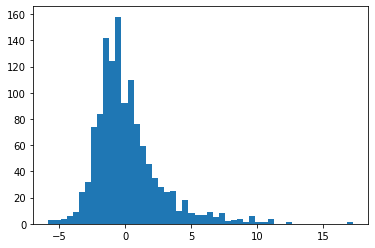

In [201]:
plt.hist(e, bins = 50)

In [ ]:
# neural net classification